# Orbit determination example
This notebook does the following:
* Download an orbit first guess from SpaceTrack
* Get laser ranging data
* Feed the data to Orekit
* Estimate the orbit
* Propagate and compare the orbit to the first guess

## OD parameters
First, some parameters need to be defined for the orbit determination:
* Satellite ID in NORAD format
* Spacecraft mass: important for the drag term
* Measurement weights: used to weight certain measurements more than others during the orbit estimation. Here, we only have range measurements and we do not know the confidence associated to these measurements, so all weights are identical
* OD date: date at which the orbit will be estimated. 
* Data collection duration: for example, if equals 2 days, the laser data from the 2 days before the OD date will be used to estimate the orbit. This value is an important trade-off for the quality of the orbit determination:
    * The longer the duration, the more ranging data is available, which can increase the quality of the estimation
    * The longer the duration, the longer the orbit must be propagated, and the higher the covariance because of the orbit perturbations such as the gravity field, drag, Sun, Moon, etc.
    * In some cases, the estimator can only converge if the time windows is small enough
    * In the case of CALIPSO, it must be kept very short because we don't know if there were orbit boosts

Satellite parameters

In [1]:
sat_list = {    
    'calipso': {
        'norad_id': 29108,  # For Space-Track TLE queries
        'mass': 560.0, # kg; https://atrain.nasa.gov/publications/CALIPSO.pdf
        'cross_section': 5.0, # m2; Estimation based on satellite's geometry
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    }
}

sc_name = 'calipso'  # Change the name to select a different satellite in the dict

In [2]:
range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

import numpy as np

from datetime import datetime
odDate = datetime(2021, 4, 19, 21, 0, 0) # Epoch of the orbit determination
collectionDuration = 6000.0 # seconds, approximately one orbit. In CALIPSO's case, only small windows work
from datetime import timedelta
# The data is taken before the epoch
startCollectionDate = odDate + timedelta(seconds=-collectionDuration)

# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 0.1 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-2
estimator_max_iterations = 25
estimator_max_evaluations = 35

Loading the ground stations from a CSV file. These ground station coordinates will be used for generated simulated measurements, for instance RA/DEC or range.

In [3]:
import pandas as pd
ground_stations_file = 'ground-stations.csv'
ground_station_df = pd.read_csv(ground_stations_file, index_col=0)
display(ground_station_df)

,longitude_deg,latitude_deg,altitude
name,,,
Svalbard,15.0,78.0,0.0
Australia,117.0,-32.0,0.0
Argentina,-65.0,-35.0,0.0
Antarctica,-75.0,-73.0,0.0
Tunka,102.5,51.7,0.0


## API credentials
The following sets up the account for SpaceTrack (for orbit data).
* A SpaceTrack account is required, it can be created for free at: https://www.space-track.org/auth/createAccount

In [4]:
# Space-Track
identity_st = input('Enter SpaceTrack username')
import getpass
password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

Enter SpaceTrack username clement@jonglez.space
Enter SpaceTrack password for account clement@jonglez.space ·····················


## Downloading CALIPSO range data file

Finding the nearest date at which a weekly data file is available.

In [5]:
from datetime import timedelta
reference_date = datetime(2015, 1, 7)
delta_time = startCollectionDate - reference_date
delta_weeks = int(delta_time.days / 7)
week_start = reference_date + timedelta(weeks=delta_weeks)

In [6]:
import requests
import urllib.request

filename = f'CPSO_10second_GT_{week_start:%Y_%m_%d}.txt'
target_url = f'https://www-calipso.larc.nasa.gov/data/TOOLS/overpass/coords/{filename}'
urllib.request.urlretrieve(target_url, filename)
#response = requests.get(target_url)
#data = response.text
#print(data[0:100])

('CPSO_10second_GT_2021_04_14.txt',
 <http.client.HTTPMessage at 0x7fa25a68faf0>)

Processing the downloaded file. The range data can be decimated using the parameter `decimation_factor` to reduce the computational load.

In [7]:
import pandas as pd

#variable space separator
df = pd.read_csv(
    filename,
    sep = '\s\s+',
    skiprows=5,
    index_col=0,
    parse_dates=True,
    engine='python'
)
df.columns = ['lat_deg', 'lon_deg', 'range_km']
df.index.name = 'datetime_utc'

usable_df = df.loc[startCollectionDate:odDate]
decimation_factor = 1
usable_df = usable_df.iloc[::decimation_factor, :]
display(usable_df)

,lat_deg,lon_deg,range_km
datetime_utc,,,
2021-04-19 19:20:00,-45.3315,-67.2500,704.3260
2021-04-19 19:20:10,-44.7363,-67.4658,704.0738
2021-04-19 19:20:20,-44.1407,-67.6781,703.8208
2021-04-19 19:20:30,-43.5448,-67.8869,703.5671
2021-04-19 19:20:40,-42.9486,-68.0926,703.3129
...,...,...,...
2021-04-19 20:59:20,-42.4227,-92.8997,703.0635
2021-04-19 20:59:30,-41.8259,-93.0995,702.8062
2021-04-19 20:59:40,-41.2288,-93.2965,702.5487


## Setting up models
Initializing Orekit and JVM

In [8]:
import orekit
orekit.initVM()

# Modified from https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/python_files/pyhelpers.py
from java.io import File
from org.orekit.data import DataProvidersManager, DirectoryCrawler
from orekit import JArray

orekit_data_dir = 'orekit-data'
DM = DataProvidersManager.getInstance()
datafile = File(orekit_data_dir)
if not datafile.exists():
    print('Directory :', datafile.absolutePath, ' not found')

crawler = DirectoryCrawler(datafile)
DM.clearProviders()
DM.addProvider(crawler)

The orbit determination needs a first guess. For this, we use Two-Line Elements. Retrieving the latest TLE prior to the beginning of the orbit determination. It is important to have a "fresh" TLE, because the newer the TLE, the better the orbit estimation.

In [9]:
rawTle = st.tle(norad_cat_id=sat_list[sc_name]['norad_id'], epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 29108U 06016B   21109.54066165  .00000226  00000-0  54070-4 0  9999
2 29108  98.2706  62.1875 0001315  79.7201 280.4148 14.62531336797058


Setting up Orekit frames and models

In [10]:
from org.orekit.utils import Constants as orekit_constants

from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
eme2000 = FramesFactory.getEME2000()
gcrf = FramesFactory.getGCRF()
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
#itrf = FramesFactory.getITRF(ITRFVersion.ITRF_2014, IERSConventions.IERS_2010, False)
# Selecting frames to use for OD
eci = eme2000
ecef = itrf

from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ecef)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

from org.orekit.time import AbsoluteDate, TimeScalesFactory
utc = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, utc)

Setting up the propagator from the initial TLEs

In [11]:
from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(eci, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_ECI = tleOrbit_TEME.getPVCoordinates(eci)

from org.orekit.orbits import CartesianOrbit
tleOrbit_ECI = CartesianOrbit(tlePV_ECI, eci, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI,
                                               integratorBuilder, PositionAngle.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sat_list[sc_name]['mass'])
propagatorBuilder.setAttitudeProvider(nadirPointing)

Adding perturbation forces to the propagator

In [12]:
# Earth gravity field with degree 64 and order 64
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider = GravityFieldFactory.getConstantNormalizedProvider(64, 64)
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(ecef, gravityProvider)
propagatorBuilder.addForceModel(gravityAttractionModel)

# Moon and Sun perturbations
from org.orekit.forces.gravity import ThirdBodyAttraction
moon_3dbodyattraction = ThirdBodyAttraction(moon)
propagatorBuilder.addForceModel(moon_3dbodyattraction)
sun_3dbodyattraction = ThirdBodyAttraction(sun)
propagatorBuilder.addForceModel(sun_3dbodyattraction)

# Solar radiation pressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cr']);
from org.orekit.forces.radiation import SolarRadiationPressure
solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid.getEquatorialRadius(),
                                                isotropicRadiationSingleCoeff)
propagatorBuilder.addForceModel(solarRadiationPressure)

# Relativity
from org.orekit.forces.gravity import Relativity
relativity = Relativity(orekit_constants.EIGEN5C_EARTH_MU)
propagatorBuilder.addForceModel(relativity)

Adding atmospheric drag to the propagator

In [13]:
# Atmospheric drag

# New CSSI loader for three-hourly atmospheric data
from org.orekit.models.earth.atmosphere.data import CssiSpaceWeatherData
cswl = CssiSpaceWeatherData("SpaceWeather-All-v1.2.txt")

from org.orekit.models.earth.atmosphere import NRLMSISE00
atmosphere = NRLMSISE00(cswl, sun, wgs84Ellipsoid)
#from org.orekit.forces.drag.atmosphere import DTM2000
#atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
from org.orekit.forces.drag import IsotropicDrag
isotropicDrag = IsotropicDrag(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cd'])
from org.orekit.forces.drag import DragForce
dragForce = DragForce(atmosphere, isotropicDrag)
propagatorBuilder.addForceModel(dragForce)

Setting up the estimator

In [14]:
from org.hipparchus.linear import QRDecomposer
matrixDecomposer = QRDecomposer(1e-11)
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
optimizer = GaussNewtonOptimizer(matrixDecomposer, False)

from org.orekit.estimation.leastsquares import BatchLSEstimator
estimator = BatchLSEstimator(optimizer, propagatorBuilder)
estimator.setParametersConvergenceThreshold(estimator_convergence_thres)
estimator.setMaxIterations(estimator_max_iterations)
estimator.setMaxEvaluations(estimator_max_evaluations)

Adding the measurements to the estimator. A new GroundStation object is created for each measurement point as it's a "virtual" ground station, i.e. the point on Earth hit by CALIPSO's laser.

In [15]:
from orekit.pyhelpers import datetime_to_absolutedate, JArray
from org.orekit.estimation.measurements import Range, AngularAzEl, ObservableSatellite, GroundStation
from org.orekit.frames import TopocentricFrame 
from org.orekit.bodies import GeodeticPoint

observableSatellite = ObservableSatellite(0) # Propagator index = 0

for receiveTime, data in usable_df.iterrows():
    ground_station = GroundStation(
        TopocentricFrame(wgs84Ellipsoid, 
                         GeodeticPoint(
                            float(np.deg2rad(data['lat_deg'])),
                            float(np.deg2rad(data['lon_deg'])),
                            0.0
                         ), 
                         "bla"
                        )
    )
    orekitRange = Range(ground_station, 
                        False, # One-way measurement
                        datetime_to_absolutedate(receiveTime),
                        float(data['range_km']*1e3),
                        range_sigma,
                        range_weight,
                        observableSatellite
                       ) # Uses date of signal reception; https://www.orekit.org/static/apidocs/org/orekit/estimation/measurements/Range.html
    estimator.addMeasurement(orekitRange)

## Performing the OD
Estimate the orbit. This step can take a long time.

In [16]:
estimatedPropagatorArray = estimator.estimate()

## Propagating the estimated orbit

In [17]:
dt = 300.0
date_start = datetime_to_absolutedate(startCollectionDate).shiftedBy(-86400.0)
date_end = datetime_to_absolutedate(odDate).shiftedBy(86400.0) # Stopping 1 day after OD date

# First propagating in ephemeris mode
estimatedPropagator = estimatedPropagatorArray[0]
estimatedInitialState = estimatedPropagator.getInitialState()
actualOdDate = estimatedInitialState.getDate()
estimatedPropagator.resetInitialState(estimatedInitialState)
estimatedPropagator.setEphemerisMode()

# Propagating from 1 day before data collection
# To 1 day after orbit determination
estimatedPropagator.propagate(date_start, datetime_to_absolutedate(odDate).shiftedBy(1 * 86400.0))
bounded_propagator = estimatedPropagator.getGeneratedEphemeris()

## Covariance analysis
Creating the LVLH frame, computing the covariance matrix in both TOD and LVLH frames

In [18]:
# Creating the LVLH frame 
# It must be associated to the bounded propagator, not the original numerical propagator
from org.orekit.frames import LocalOrbitalFrame
from org.orekit.frames import LOFType
lvlh = LocalOrbitalFrame(eci, LOFType.LVLH, bounded_propagator, 'LVLH')

# Getting covariance matrix in ECI frame
covMat_eci_java = estimator.getPhysicalCovariances(1.0e-10)

# Converting matrix to LVLH frame
# Getting an inertial frame aligned with the LVLH frame at this instant
# The LVLH is normally not inertial, but this should not affect results too much
# Reference: David Vallado, Covariance Transformations for Satellite Flight Dynamics Operations, 2003
eci2lvlh_frozen = eci.getTransformTo(lvlh, actualOdDate).freeze() 

# Computing Jacobian
from org.orekit.utils import CartesianDerivativesFilter
from orekit.pyhelpers import JArray_double2D
jacobianDoubleArray = JArray_double2D(6, 6)
eci2lvlh_frozen.getJacobian(CartesianDerivativesFilter.USE_PV, jacobianDoubleArray)
from org.hipparchus.linear import Array2DRowRealMatrix
jacobian = Array2DRowRealMatrix(jacobianDoubleArray)
# Applying Jacobian to convert matrix to lvlh
covMat_lvlh_java = jacobian.multiply(
    covMat_eci_java.multiply(jacobian.transpose()))

# Converting the Java matrices to numpy
import numpy as np
covarianceMat_eci = np.matrix([covMat_eci_java.getRow(iRow) 
                              for iRow in range(0, covMat_eci_java.getRowDimension())])
covarianceMat_lvlh = np.matrix([covMat_lvlh_java.getRow(iRow) 
                              for iRow in range(0, covMat_lvlh_java.getRowDimension())])

Computing the position and velocity standard deviation 

In [19]:
pos_std_crossTrack = np.sqrt(covarianceMat_lvlh[0,0])
pos_std_alongTrack = np.sqrt(covarianceMat_lvlh[1,1])
pos_std_outOfPlane = np.sqrt(covarianceMat_lvlh[2,2])
print(f'Position std: cross-track {pos_std_crossTrack:.3e} m, along-track {pos_std_alongTrack:.3e} m, out-of-plane {pos_std_outOfPlane:.3e} m')

vel_std_crossTrack = np.sqrt(covarianceMat_lvlh[3,3])
vel_std_alongTrack = np.sqrt(covarianceMat_lvlh[4,4])
vel_std_outOfPlane = np.sqrt(covarianceMat_lvlh[5,5])
print(f'Velocity std: cross-track {vel_std_crossTrack:.3e} m/s, along-track {vel_std_alongTrack:.3e} m/s, out-of-plane {vel_std_outOfPlane:.3e} m/s')

Position std: cross-track 5.749e-01 m, along-track 2.971e+01 m, out-of-plane 1.046e+02 m
Velocity std: cross-track 3.156e-02 m/s, along-track 3.634e-04 m/s, out-of-plane 1.440e-01 m/s


## Analyzing residuals
Getting the estimated and measured ranges.

In [20]:
propagatorParameters   = estimator.getPropagatorParametersDrivers(True)
measurementsParameters = estimator.getMeasurementsParametersDrivers(True)

lastEstimations = estimator.getLastEstimations()
valueSet = lastEstimations.values()
estimatedMeasurements = valueSet.toArray()
keySet = lastEstimations.keySet()
realMeasurements = keySet.toArray()

from org.orekit.estimation.measurements import EstimatedMeasurement
from orekit.pyhelpers import absolutedate_to_datetime

import pandas as pd
range_residuals = pd.DataFrame(columns=['range'])

for estMeas, realMeas in zip(estimatedMeasurements, realMeasurements):
    estMeas = EstimatedMeasurement.cast_(estMeas)
    estimatedValue = estMeas.getEstimatedValue()
    pyDateTime = absolutedate_to_datetime(estMeas.date)
    
    observedValue = Range.cast_(realMeas).getObservedValue()
    range_residuals.loc[pyDateTime] = np.array(observedValue) - np.array(estimatedValue)
        
#display(range_residuals)

Setting up Plotly for offline mode

In [21]:
import plotly.io as pio
#pio.renderers.default = 'jupyterlab+notebook+png'  # Uncomment for interactive plots
pio.renderers.default = 'png'

Plotting range residuals

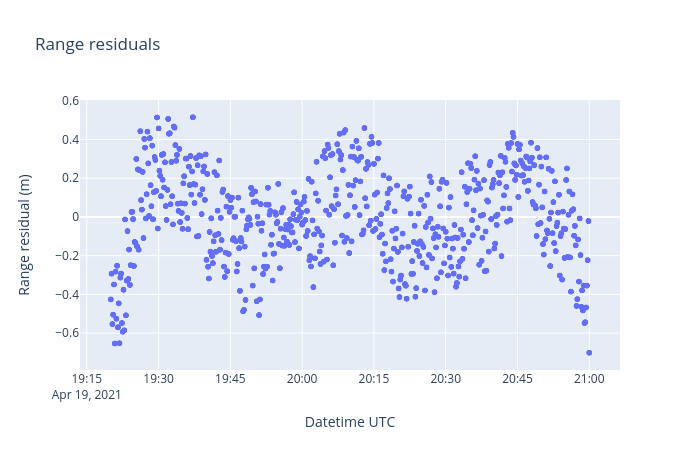

In [22]:
import plotly.graph_objs as go

trace = go.Scattergl(
    x=range_residuals.index, y=range_residuals['range'],
    mode='markers',
    name='Range'
)

data = [trace]

layout = go.Layout(
    title = 'Range residuals',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Range residual (m)'
    )
)

fig = dict(data=data, layout=layout)

pio.show(fig)

## Propagating the solution 
Propagating the solution and:
* Saving the PV coordinates from both the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the CPF file.

Also logging:
* Latitude/Longitude/Altitude

For analysis purposes, the propagation time window is here from one day before to one day after the epoch.

In [23]:
# Propagating the bounded propagator to retrieve the intermediate states

from slrDataUtils import orekitPV2dataframe

PV_eci_df = pd.DataFrame(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
PV_ecef_df = pd.DataFrame(columns=['x', 'y', 'z', 'pos_norm', 'vx', 'vy', 'vz'])
PV_tle_eci_df = pd.DataFrame(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
lat_lon_df = pd.DataFrame(columns=['lat_deg', 'lon_deg', 'alt_m'])
deltaPV_tle_lvlh_df = pd.DataFrame(columns=['x', 'y', 'z', 'pos_norm', 'vx', 'vy', 'vz', 'vel_norm'])
deltaPV_cpf_lvlh_df = pd.DataFrame(columns=['x', 'y', 'z', 'norm'])

date_current = date_start
while date_current.compareTo(date_end) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    spacecraftState = bounded_propagator.propagate(date_current)
    
    geodetic_point = wgs84Ellipsoid.transform(spacecraftState.getPVCoordinates(ecef).getPosition(),
                                              ecef,
                                              date_current)
    lat_lon_df.loc[datetime_current] = [np.rad2deg(geodetic_point.getLatitude()),
                                        np.rad2deg(geodetic_point.getLongitude()),
                                        geodetic_point.getAltitude()]
    
    '''
    When getting PV coordinates using the SGP4 propagator in LVLH frame, 
    it is actually a "delta" from the PV coordinates resulting from the orbit determination
    because this LVLH frame is centered on the satellite's current position based on the orbit determination
    '''
    deltaPV_lvlh = sgp4Propagator.getPVCoordinates(date_current, lvlh)
    deltaPV_tle_lvlh_df.loc[datetime_current] = [deltaPV_lvlh.getPosition().getX(),
                                                 deltaPV_lvlh.getPosition().getY(), 
                                                 deltaPV_lvlh.getPosition().getZ(),
                                                 deltaPV_lvlh.getPosition().getNorm(),
                                                 deltaPV_lvlh.getVelocity().getX(),
                                                 deltaPV_lvlh.getVelocity().getY(), 
                                                 deltaPV_lvlh.getVelocity().getZ(),
                                                 deltaPV_lvlh.getVelocity().getNorm()]
    
    
    date_current = date_current.shiftedBy(dt)    

Spacecraft's latitude/longitude/altitude

In [24]:
lat_lon_df

,lat_deg,lon_deg,alt_m
2021-04-18 19:20:00,81.534088,-179.484191,697594.926055
2021-04-18 19:25:00,68.232100,124.298114,696008.853261
2021-04-18 19:30:00,50.789342,112.031613,692532.689928
2021-04-18 19:35:00,32.830495,105.928791,688921.312645
2021-04-18 19:40:00,14.697556,101.500749,687183.710030
...,...,...,...
2021-04-20 20:40:00,70.030270,107.795182,696290.287243
2021-04-20 20:45:00,52.705196,94.048206,692978.606638
2021-04-20 20:50:00,34.776813,87.620379,689317.171181
2021-04-20 20:55:00,16.656291,83.089021,687320.786977


## Measurement generation

Creating measurement builders to later retrieve the simulated measurements from the estimated orbit.

The PV builder is not strictly necessary, as the spacecraft's position&velocity can also be retrieved directly during propagation above (the position&velocity are direct outputs of the propagation and do not need the same post-processing as ground station related measurements).

No noise generators are passed to the measurement builders, which means that the sigma values are not used.

In [25]:
sigma_position = 1.0  # Position noise in meters
sigma_velocity = 1e-3 # Velocity noise in meters per second
step_pv = 1.0  # Step time for output PV data

sigma_range = 1.0  # Range noise in meters
sigma_range_rate = 1e-3  # Range rate noise in meters per second
sigma_az = float(np.deg2rad(0.01))  # Azimuth noise in radians
sigma_el = float(np.deg2rad(0.01))  # Elevation noise in radians
sigma_ra = float(np.deg2rad(0.01))  # Right ascension noise in radians
sigma_dec = float(np.deg2rad(0.01))  # Declination noise in radians
step_ground_station_measurements = 1.0  # When a ground station is in view, take measurements every second

In [26]:
from org.orekit.bodies import GeodeticPoint
from org.orekit.frames import TopocentricFrame
from org.orekit.propagation.events import ElevationDetector
from org.orekit.estimation.measurements import GroundStation
from org.orekit.estimation.measurements.generation import PVBuilder, RangeBuilder, RangeRateBuilder, AngularAzElBuilder, AngularRaDecBuilder, EventBasedScheduler, SignSemantic, Generator, ContinuousScheduler
from org.orekit.time import FixedStepSelector
from org.orekit.estimation.measurements import ObservableSatellite
from org.orekit.propagation.events.handlers import ContinueOnEvent

meas_generator = Generator()
meas_generator.addPropagator(bounded_propagator)

# Add PV builder
meas_generator.addScheduler(
    ContinuousScheduler(
        PVBuilder(None,  # no noise
                  sigma_position,
                  sigma_velocity,
                  1.0,  # Base weight
                  observableSatellite), 
        FixedStepSelector(step_pv, utc))
)

for gs_name, gs_data in ground_station_df.iterrows():
    geodetic_point = GeodeticPoint(float(np.deg2rad(gs_data['latitude_deg'])),
                                   float(np.deg2rad(gs_data['longitude_deg'])),
                                   float(gs_data['altitude']))
    topocentric_frame = TopocentricFrame(wgs84Ellipsoid, geodetic_point, gs_name)
    ground_station_df.loc[gs_name, 'GroundStation'] = GroundStation(topocentric_frame)

    # Range builder
    meas_generator.addScheduler(
        EventBasedScheduler(
            RangeBuilder(None, 
                         GroundStation(topocentric_frame), 
                         False,  # one-way, this is important for telescope observations
                         sigma_range, 
                         1.0,  # Base weight
                         observableSatellite), 
            FixedStepSelector(step_ground_station_measurements, utc), 
            bounded_propagator, 
            ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
            SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
    )

    # Range rate builder
    meas_generator.addScheduler(
        EventBasedScheduler(
            RangeRateBuilder(None,  # no noise
                             GroundStation(topocentric_frame), 
                             True,  # two-way
                             sigma_range_rate, 
                             1.0,  # Base weight
                             observableSatellite), 
            FixedStepSelector(step_ground_station_measurements, utc), 
            bounded_propagator, 
            ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
            SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
    )

    # Az/el builder
    meas_generator.addScheduler(
        EventBasedScheduler(
            AngularAzElBuilder(None,  # no noise
                               GroundStation(topocentric_frame),
                               [sigma_az, sigma_el], 
                               [1.0, 1.0],  # Base weight
                               observableSatellite), 
            FixedStepSelector(step_ground_station_measurements, utc), 
            bounded_propagator, 
            ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
            SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
    )

    # RA/DEC builder
    meas_generator.addScheduler(
        EventBasedScheduler(
            AngularRaDecBuilder(None,  # no noise
                               GroundStation(topocentric_frame),
                               eci,  # RA/DEC measurements are defined in Earth-centered inertial frame
                               [sigma_ra, sigma_dec], 
                               [1.0, 1.0],  # Base weight
                               observableSatellite), 
            FixedStepSelector(step_ground_station_measurements, utc), 
            bounded_propagator, 
            ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
            SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
    )

Propagating, retrieving the generated measurements.

Warning: the cell below cannot be run a second time without running the cell above again before. Otherwise the result structure will be empty.

In [27]:
from orekit.pyhelpers import absolutedate_to_datetime
from org.orekit.estimation.measurements import ObservedMeasurement, PV, Range, RangeRate, AngularAzEl, AngularRaDec
from org.orekit.utils import PVCoordinates
from org.hipparchus.geometry.euclidean.threed import Vector3D

generated = meas_generator.generate(datetime_to_absolutedate(startCollectionDate), datetime_to_absolutedate(odDate))
pv_itrf_df = pd.DataFrame(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
pv_eme2000_df = pd.DataFrame(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
range_df = pd.DataFrame(columns=['ground_station', 'range'])
range_rate_df = pd.DataFrame(columns=['ground_station', 'range_rate'])
az_el_df = pd.DataFrame(columns=['ground_station', 'az_deg', 'el_deg'])
ra_dec_df = pd.DataFrame(columns=['ground_station', 'ra_deg', 'dec_deg'])

for meas in generated.toArray():
    observed_meas = ObservedMeasurement.cast_(meas)
    py_datetime = absolutedate_to_datetime(observed_meas.date)

    if PV.instance_(observed_meas):
        '''
        PV objects are given in propagator frame (ECI)
        We transform them to ITRF and to EME2000 frame (depending on the user's needs)
        '''
        observed_pv = PV.cast_(observed_meas)
        pv_eci_jarray = observed_meas.getObservedValue()
        pv_eci = PVCoordinates(Vector3D(pv_eci_jarray[0:3]), Vector3D(pv_eci_jarray[3:6]))
        eci_to_itrf = eci.getTransformTo(itrf, observed_meas.date)
        pv_itrf = eci_to_itrf.transformPVCoordinates(pv_eci)
        pv_itrf_df.loc[py_datetime] = np.concatenate(([np.array(pv_itrf.getPosition().toArray()),
                                                       np.array(pv_itrf.getVelocity().toArray())]))
        
        eci_to_eme2000 = eci.getTransformTo(eme2000, observed_meas.date)
        pv_eme2000 = eci_to_eme2000.transformPVCoordinates(pv_eci)
        pv_eme2000_df.loc[py_datetime] = np.concatenate(([np.array(pv_eme2000.getPosition().toArray()),
                                                       np.array(pv_eme2000.getVelocity().toArray())]))
        
        

    elif Range.instance_(observed_meas):
        observed_range = Range.cast_(observed_meas)
        range_df.loc[py_datetime] = np.concatenate(([observed_range.getStation().getBaseFrame().name], 
                                                    np.array(observed_range.getObservedValue())))

    elif RangeRate.instance_(observed_meas):
        observed_range_rate = RangeRate.cast_(observed_meas)
        range_rate_df.loc[py_datetime] = np.concatenate(([observed_range_rate.getStation().getBaseFrame().name], 
                                                         np.array(observed_range_rate.getObservedValue())))

    elif AngularAzEl.instance_(observed_meas):
        observed_az_el = AngularAzEl.cast_(observed_meas)
        az_el_df.loc[py_datetime] = np.concatenate(([observed_az_el.getStation().getBaseFrame().name], 
                                                    np.rad2deg(observed_az_el.getObservedValue())))

    elif AngularRaDec.instance_(observed_meas):
        observed_ra_dec = AngularRaDec.cast_(observed_meas)
        ra_dec_df.loc[py_datetime] = np.concatenate(([observed_ra_dec.getStation().getBaseFrame().name], 
                                                     np.rad2deg(observed_ra_dec.getObservedValue())))

Position and velocity in ITRF frame

In [28]:
pv_itrf_df

,x,y,z,vx,vy,vz
2021-04-19 19:20:00,1.924822e+06,-4.568520e+06,-5.041413e+06,280.957011,-5560.983210,5150.741715
2021-04-19 19:20:01,1.925101e+06,-4.574079e+06,-5.036259e+06,277.990259,-5555.903791,5156.427400
2021-04-19 19:20:02,1.925378e+06,-4.579632e+06,-5.031100e+06,275.023920,-5550.817674,5162.107314
2021-04-19 19:20:03,1.925651e+06,-4.585180e+06,-5.025935e+06,272.057997,-5545.724866,5167.781449
2021-04-19 19:20:04,1.925922e+06,-4.590723e+06,-5.020764e+06,269.092496,-5540.625371,5173.449799
...,...,...,...,...,...,...
2021-04-19 20:59:56,-3.307806e+05,-5.372073e+06,-4.584675e+06,-2099.659040,-4655.262224,5612.014295
2021-04-19 20:59:57,-3.328804e+05,-5.376726e+06,-4.579060e+06,-2099.965532,-4648.932022,5617.187974
2021-04-19 20:59:58,-3.349805e+05,-5.381371e+06,-4.573440e+06,-2100.268743,-4642.596513,5622.355353
2021-04-19 20:59:59,-3.370809e+05,-5.386011e+06,-4.567815e+06,-2100.568672,-4636.255706,5627.516427


Position and velocity in EME2000 frame

In [29]:
pv_eme2000_df

,x,y,z,vx,vy,vz
2021-04-19 19:20:00,1.629402e+06,4.678402e+06,-5.044775e+06,3193.674912,4430.334291,5144.219082
2021-04-19 19:20:01,1.632595e+06,4.682830e+06,-5.039628e+06,3191.839439,4425.066779,5149.908555
2021-04-19 19:20:02,1.635786e+06,4.687253e+06,-5.034475e+06,3190.000359,4419.794244,5155.592263
2021-04-19 19:20:03,1.638975e+06,4.691670e+06,-5.029317e+06,3188.157674,4414.516692,5161.270200
2021-04-19 19:20:04,1.642162e+06,4.696082e+06,-5.024153e+06,3186.311386,4409.234129,5166.942359
...,...,...,...,...,...,...
2021-04-19 20:59:56,1.887238e+06,5.036988e+06,-4.588564e+06,3020.405959,3969.880321,5605.846700
2021-04-19 20:59:57,1.890257e+06,5.040955e+06,-4.582955e+06,3018.278877,3964.205547,5611.024761
2021-04-19 20:59:58,1.893274e+06,5.044916e+06,-4.577342e+06,3016.148378,3958.526261,5616.196530
2021-04-19 20:59:59,1.896289e+06,5.048872e+06,-4.571723e+06,3014.014465,3952.842469,5621.362001


Azimuth and elevation, here selecting only the Tunka ground station.

In [30]:
az_el_df[az_el_df['ground_station'] == 'Tunka']

,ground_station,az_deg,el_deg
2021-04-19 20:02:23,Tunka,15.115783617032385,7.66812839220923
2021-04-19 20:02:24,Tunka,15.122700514659531,7.751957209168841
2021-04-19 20:02:25,Tunka,15.129634927361755,7.836097603463941
2021-04-19 20:02:26,Tunka,15.136587045799004,7.9205522614634365
2021-04-19 20:02:27,Tunka,15.143557063116962,8.005323899386005
...,...,...,...
2021-04-19 20:14:21,Tunka,-164.13817079955322,0.3036960741738218
2021-04-19 20:14:22,Tunka,-164.13383659179337,0.24119900191966986
2021-04-19 20:14:23,Tunka,-164.12951251781402,0.17884562380385266
2021-04-19 20:14:24,Tunka,-164.1251985181108,0.11663496456349737


Right ascension and declination when the spacecraft is in view of any station. Although the RA/DEC coordinates are in theory independent on the station's position, here the time-of-flight to a ground telescope for instance plays a role.

In [31]:
ra_dec_df

,ground_station,ra_deg,dec_deg
2021-04-19 19:20:00,Argentina,-73.66852095441548,-76.67135779903485
2021-04-19 19:20:01,Argentina,-72.86381262705333,-76.74465684573238
2021-04-19 19:20:02,Argentina,-72.04453000559761,-76.81573644924268
2021-04-19 19:20:03,Argentina,-71.21063690261401,-76.88450069522003
2021-04-19 19:20:04,Argentina,-70.36212129471667,-76.95085159654056
...,...,...,...
2021-04-19 20:59:56,Argentina,-3.1530873942438413,-19.996196891839794
2021-04-19 20:59:57,Argentina,-3.0612274494554192,-19.865481796190636
2021-04-19 20:59:58,Argentina,-2.96971573053403,-19.73473397801875
2021-04-19 20:59:59,Argentina,-2.878551349264586,-19.603955737852363


## Comparison with TLE

In [32]:
import numpy as np
import plotly.graph_objs as go

# Rectangles to visualise time window for orbit determination.

od_window_rectangle =  {
    'type': 'rect',
    # x-reference is assigned to the x-values
    'xref': 'x',
    # y-reference is assigned to the plot paper [0,1]
    'yref': 'paper',
    'x0': startCollectionDate,
    'y0': 0,
    'x1': odDate,
    'y1': 1,
    'fillcolor': '#d3d3d3',
    'opacity': 0.5,
    'line': {
        'width': 0,
    }
}

Plotting the components of the position different between the TLE and the estimation, in LVLH frame. The grey area represents the time window where range measurements were used to perform the orbit determination.

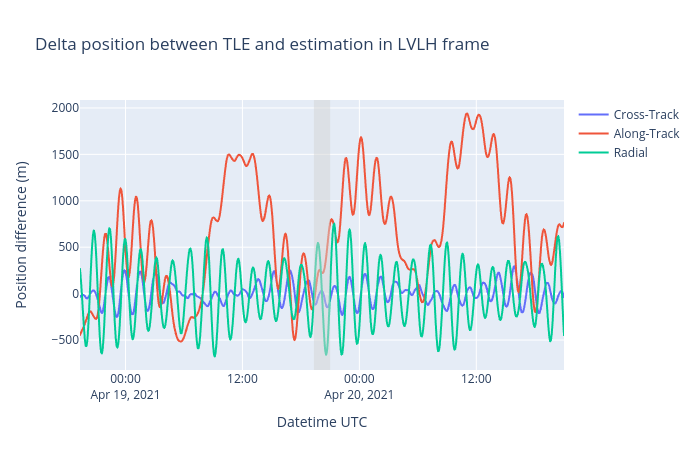

In [33]:
import plotly.graph_objs as go

traceX = go.Scattergl(
    x = deltaPV_tle_lvlh_df['x'].index,
    y = deltaPV_tle_lvlh_df['x'],
    mode='lines',
    name='Cross-Track'
)

traceY = go.Scattergl(
    x = deltaPV_tle_lvlh_df['y'].index,
    y = deltaPV_tle_lvlh_df['y'],
    mode='lines',
    name='Along-Track'
)

traceZ = go.Scattergl(
    x = deltaPV_tle_lvlh_df['z'].index,
    y = deltaPV_tle_lvlh_df['z'],
    mode='lines',
    name='Radial'
)

data = [traceX, traceY, traceZ]

layout = go.Layout(
    title = 'Delta position between TLE and estimation in LVLH frame',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Position difference (m)'
    ),
    shapes=[od_window_rectangle]
)

fig = dict(data=data, layout=layout)

pio.show(fig)